# Cleaning Chicago Crime Data

I have downloaded the dataset from [the City of Chicago Data Portal](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2). The data includes all crime information occurred in Chicago since 2001 AND recorded by CPD's CLEAR (Citizen Law Enforcement Analysis and Reporting) system. The data is broken down by factors such as time, crime id, offense type, arrest, and crime location. 

The end purpose of this notebook is to fully clean the data, possibly by developing a pipeline, and to reduce difficulties in future analysis and visualization. This outcome is achieved through three steps: in step 1, we condense the dataset by truancating crimes that happened before 2015; in step 2, we clean the simplified data by transforming variable types, deselecting unnecessary information, and ...(to be filled), and lastly, in step 3, we produce summary tables and graphs. 


## Step 0: Loading libraries

We will use `json` and `requests` for basic data gathering, `pandas` and `numpy` for data cleaning and wrangling, and `matplotlib` and `seaborn` for visualization.

In [1]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

## Part I: Initial Data Cleaning

Before moving to any analysis, I need to cut out the data size to only include data from year 2015 in order to be consistent with the time frame in other data of this project. To do that, I filtered the data by variable `Year` and save the new, filtered dataset in the `data` subdirectory.

In [2]:
crime_all_data = pd.read_csv("Crimes_2001_to_Present.csv")

c:\Users\liu00\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Our dataframe has over 7M data and 20+ variables!! Thinking about the space needed to store these 7M data, this is clearly too many rows. With this large data size, transforming the data will also be very time-consuming. We surely don't want to spend hours waiting for the codes to run, right? We thus need to reduce the dimension by filtering out data that is out of scope of our analysis.

In [4]:
crime_all_data.shape

(7642176, 22)

In [9]:
crime_all_data[crime_all_data.Year >= 2015].to_csv("data/crimes_from_2015.csv", index= False)

## Part II Data Cleaning and Wrangling

After getting the dataset that has gone through dimension reduction steps, now is a great time to peak at our data! What information does the data provide? How many people were arrested during the time frame? Which year has the most crimes in Chicago? What's the most occurred crime type? Which police district had the most crimes and arrests? These are just some of the many questions we can think of.

But first, let's look at our data! What are these 22 variables? We use the first 10 rows to grasp a sense of what our data looks like.

In [26]:
crimes = pd.read_csv("data/crimes_from_2015.csv")

c:\Users\liu00\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Our data now has 1.9M rows. This is 3/4 down from the original dataset

In [29]:
crimes.shape

(1923350, 22)

In [13]:
crimes.head(5)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10224738,HY411648,09/05/2015 01:30:00 PM,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,12.0,61.0,08B,1165074.0,1875917.0,2015,02/10/2018 03:50:01 PM,41.815117,-87.670000,"(41.815117282, -87.669999562)"
1,10224739,HY411615,09/04/2015 11:30:00 AM,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,...,29.0,25.0,06,1138875.0,1904869.0,2015,02/10/2018 03:50:01 PM,41.895080,-87.765400,"(41.895080471, -87.765400451)"
2,11646166,JC213529,09/01/2018 12:01:00 AM,082XX S INGLESIDE AVE,0810,THEFT,OVER $500,RESIDENCE,False,True,...,8.0,44.0,06,NaN,NaN,2018,04/06/2019 04:04:43 PM,NaN,NaN,NaN
3,10224740,HY411595,09/05/2015 12:45:00 PM,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,...,35.0,21.0,18,1152037.0,1920384.0,2015,02/10/2018 03:50:01 PM,41.937406,-87.716650,"(41.937405765, -87.716649687)"
4,10224741,HY411610,09/05/2015 01:00:00 PM,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,...,28.0,25.0,08A,1141706.0,1900086.0,2015,02/10/2018 03:50:01 PM,41.881903,-87.755121,"(41.881903443, -87.755121152)"
5,10224742,HY411435,09/05/2015 10:55:00 AM,082XX S LOOMIS BLVD,0610,BURGLARY,FORCIBLE ENTRY,RESIDENCE,False,False,...,21.0,71.0,05,1168430.0,1850165.0,2015,02/10/2018 03:50:01 PM,41.744379,-87.658431,"(41.744378879, -87.658430635)"
6,10224743,HY411629,09/04/2015 06:00:00 PM,021XX W CHURCHILL ST,0620,BURGLARY,UNLAWFUL ENTRY,RESIDENCE-GARAGE,False,False,...,32.0,24.0,05,1161628.0,1912157.0,2015,02/10/2018 03:50:01 PM,41.914636,-87.681631,"(41.914635603, -87.681630909)"
7,10224744,HY411605,09/05/2015 01:00:00 PM,025XX W CERMAK RD,0860,THEFT,RETAIL THEFT,GROCERY FOOD STORE,True,False,...,25.0,31.0,06,1159734.0,1889313.0,2015,09/17/2015 11:37:18 AM,41.851989,-87.689219,"(41.851988885, -87.689219118)"
8,10224745,HY411654,09/05/2015 11:30:00 AM,031XX W WASHINGTON BLVD,0320,ROBBERY,STRONGARM - NO WEAPON,STREET,False,True,...,27.0,27.0,03,1155536.0,1900515.0,2015,02/10/2018 03:50:01 PM,41.882814,-87.704326,"(41.88281374, -87.704325717)"
9,11645836,JC212333,05/01/2016 12:25:00 AM,055XX S ROCKWELL ST,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,False,False,...,15.0,63.0,11,NaN,NaN,2016,04/06/2019 04:04:43 PM,NaN,NaN,NaN


The 22 variables can be roughly grouped into a few categories:

| Category | Variables Belong to this Category|
| ------ | ------------------------|
| Crime| ID, Case Number |
| Crime Type and Info | IUCR, Primary Type, Description, Arrest, Domestic, FBI Code
| Time| Date, Year, Updated On|
| Location| Block, Location Description, Ward, Community Area|
| Police Area| Beat, District|
| Geographic Location| X Coordinate, Y Coordinate, Longitude, Latitude, Location|

These 22 variables own 4 data types: int65 (representing integer), (Pandas) object (this is pandas' way of calling strings, i.e. words), bool (booleans, i.e. T/F), and float (numbers with decimals). 

In [17]:
crimes.dtypes

ID                        int64
Case Number              object
Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                 object
X Coordinate            float64
Y Coordinate            float64
Year                      int64
Updated On               object
Latitude                float64
Longitude               float64
Location                 object
dtype: object

As we are able to tell from the table above, there are a lot of overlaps on the information in each category. For example, `IUCR` and `FBI Code` represent the same type of crime but under distinct crime classification systems (IUCR stands for Illinois Uniform Crime Report), for which we can pick one of them. Similarily, `block`, `ward`, and `community areas` represent the same location on different scales. Moreover, some variables are related. For instance, because variables `primary type` and `description` are both explanations to the IUCR code, we can use the former twp to replace the latter, which gives us a more intuitive sense of the crime that corresponds to the case number. With this being known, within each category, we only need to pick variables that best characterize the information. These variables are:
  
| Category | Variables Belong to this Category|
| ------ | ------------------------|
| Crime| Case Number |
| Crime Type and Info |Primary Type, Description, Arrest, Domestic|
| Time| Date, Year|
| Location| Location Description, Ward, Community Area|
| Police Area| Beat, District|
| Geographic Location|Longitude, Latitude|

In [34]:
crime = crimes.drop(["ID", "FBI Code", "Location", "Block", "IUCR", "Updated On", "X Coordinate", "Y Coordinate"], axis = 1)

crime.head(5)

,Case Number,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Year,Latitude,Longitude
0,HY411648,09/05/2015 01:30:00 PM,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,924,9.0,12.0,61.0,2015,41.815117,-87.670000
1,HY411615,09/04/2015 11:30:00 AM,THEFT,POCKET-PICKING,CTA BUS,False,False,1511,15.0,29.0,25.0,2015,41.895080,-87.765400
2,JC213529,09/01/2018 12:01:00 AM,THEFT,OVER $500,RESIDENCE,False,True,631,6.0,8.0,44.0,2018,NaN,NaN
3,HY411595,09/05/2015 12:45:00 PM,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,1412,14.0,35.0,21.0,2015,41.937406,-87.716650
4,HY411610,09/05/2015 01:00:00 PM,ASSAULT,SIMPLE,APARTMENT,False,True,1522,15.0,28.0,25.0,2015,41.881903,-87.755121
5,HY411435,09/05/2015 10:55:00 AM,BURGLARY,FORCIBLE ENTRY,RESIDENCE,False,False,614,6.0,21.0,71.0,2015,41.744379,-87.658431
6,HY411629,09/04/2015 06:00:00 PM,BURGLARY,UNLAWFUL ENTRY,RESIDENCE-GARAGE,False,False,1434,14.0,32.0,24.0,2015,41.914636,-87.681631
7,HY411605,09/05/2015 01:00:00 PM,THEFT,RETAIL THEFT,GROCERY FOOD STORE,True,False,1034,10.0,25.0,31.0,2015,41.851989,-87.689219
8,HY411654,09/05/2015 11:30:00 AM,ROBBERY,STRONGARM - NO WEAPON,STREET,False,True,1222,12.0,27.0,27.0,2015,41.882814,-87.704326
9,JC212333,05/01/2016 12:25:00 AM,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,False,False,824,8.0,15.0,63.0,2016,NaN,NaN


Now we are ready to do two things: change the types of some variables and inspect missing values (NaN). These two steps are important for our analysis because it boosts our familiarity with data.

Let's start with looking at which columns have missing values (NAs). We found out around 10% of longitudes and latitudes are not entered to the database, which may be a drawback when we create geospatial visualizations. Around 0.4% of location description is also missing. We can ignore them at this moment because from a statisical standpoint, a small share of missing values affects little on the statistical powers of our analysis (in the context of regressions, deleting this 0.4% percent won't make our hypothese testing less valid). There are also some missing values across variables `District`, `Ward`, and `Community Area`, which we can feel safe to treat them with the complete case approach (i.e. taking out the missing data).       


In [42]:
crime.isna().sum()

Case Number                  0
Date                         0
Primary Type                 0
Description                  0
Location Description      8024
Arrest                       0
Domestic                     0
Beat                         0
District                     1
Ward                        51
Community Area               1
Year                         0
Latitude                198683
Longitude               198683
dtype: int64

In [44]:
crime = crime.dropna(subset=['Ward', 'District', 'Community Area'])
crime.isna().sum()

Case Number                  0
Date                         0
Primary Type                 0
Description                  0
Location Description      8024
Arrest                       0
Domestic                     0
Beat                         0
District                     0
Ward                         0
Community Area               0
Year                         0
Latitude                198673
Longitude               198673
dtype: int64

Next, we focus on converting variable types. This is comprised with three substeps: first, we convert `District`, `Ward`, and `Community Area` to integers; second, we make variable `Date` a datetime object, which is a date/time-specific type in Python.  

Let's start with the first step. Because there are multiple variables that need to be transformed, we apply a for-loop here. 

In [45]:
for i in [8, 9, 10]:
   crime.iloc[:,i] = crime.iloc[:, i].astype(int)

In [47]:
#for j in [0,1,2,3,4, 7, 8, 9, 10, 11]:
#    crime.iloc[:,j] = crime.iloc[:,j].astype(str)

Now the second step:

In [50]:
crime.loc[:,"Date"] = pd.to_datetime(crime["Date"], infer_datetime_format=True)

With another look of eyes, we are sure that all variables are in the right format. We are ready to move forward! How exciting!

In [51]:
crime.dtypes

Case Number                     object
Date                    datetime64[ns]
Primary Type                    object
Description                     object
Location Description            object
Arrest                            bool
Domestic                          bool
Beat                            object
District                        object
Ward                            object
Community Area                  object
Year                            object
Latitude                       float64
Longitude                      float64
dtype: object

In [ ]:
crime.to_csv("data/cleaned_crimes_from_2015.csv", index=False)

In [ ]:
crime.to_pickle("data/cleaned_crimes_from_2015.pkl")

## Part III: Explorative Data Analysis:

Now it's finally the time to answer our questions posed in part II. 

In [ ]:
crime = pd.read_pickle("data/cleaned_crimes_from_2015.pkl")

### *Q1: Which year has the most crimes?*

In [108]:
count_by_year = crime.loc[:, "Year"].value_counts().sort_index(ascending=True).to_frame()
count_by_year = count_by_year.reset_index()
count_by_year.columns = ["Year", "Crime Counts"]
count_by_year

,Year,Crime Counts
0,2015,264698
1,2016,269751
2,2017,268984
3,2018,268667
4,2019,261110
5,2020,211881
6,2021,207872
7,2022,170335


[(0.0, 300000.0),
 Text(0.5, 1.0, 'Total Crimes in Chicago Between 2015 and 2022')]

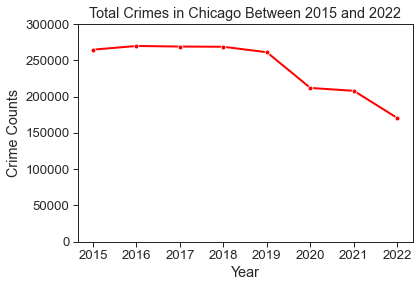

In [114]:
sns.set_context("paper", font_scale = 1.5)
sns.set_style("ticks")
p = sns.lineplot(x = "Year", y = "Crime Counts", data = count_by_year, marker = "o", color = "red", linewidth=2)
p.set(ylim = [0, 300000], title = "Total Crimes in Chicago Between 2015 and 2022")

### *Q2: Which type of crime was the most common? Which was the least?*

In [115]:
count_by_type = crime.loc[:, "Primary Type"].value_counts().sort_index(ascending=True).to_frame()
count_by_type = count_by_type.reset_index()
count_by_type.columns = ["Type", "Crime Counts"]
count_by_type

,Type,Crime Counts
0,ARSON,3590
1,ASSAULT,150235
2,BATTERY,360695
3,BURGLARY,82726
4,CONCEALED CARRY LICENSE VIOLATION,957
5,CRIM SEXUAL ASSAULT,6784
6,CRIMINAL DAMAGE,212646
7,CRIMINAL SEXUAL ASSAULT,5144
8,CRIMINAL TRESPASS,43983
9,DECEPTIVE PRACTICE,139787


In [127]:
count_by_district = crime.loc[:, "District"].value_counts(ascending=False).to_frame()
count_by_district = count_by_district.reset_index()
count_by_district.columns = ["Police District", "Crime Counts"]
count_by_district

,Police District,Crime Counts
0,11,132269
1,6,120459
2,8,120079
3,4,108570
4,7,101710
5,25,100712
6,1,99354
7,18,99215
8,12,97328
9,3,92991


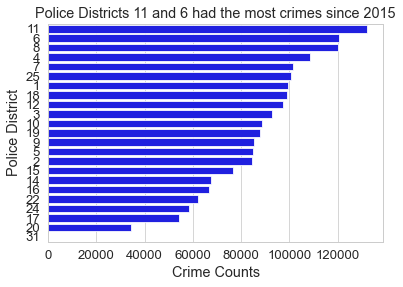

In [137]:
sns.set_style("whitegrid")
sns.barplot(y = "Police District", x = "Crime Counts", data = count_by_district, orient = "h", color = "b", order=count_by_district.sort_values('Crime Counts', ascending = False).loc[:, "Police District"]).set(title = "Police Districts 11 and 6 had the most crimes since 2015")
plt.xlabel = ""


In [133]:
count_by_district.sort_values('Crime Counts').loc[:, "Police District"]

22    31
21    20
20    17
19    24
18    22
17    16
16    14
15    15
14     2
13     5
12     9
11    19
10    10
9      3
8     12
7     18
6      1
5     25
4      7
3      4
2      8
1      6
0     11
Name: Police District, dtype: int64